In [ ]:
!pip install albumentations
!pip install opencv-python-headless
!pip install ultralytics
!pip install torch torchvision

import os
import shutil
from sklearn.model_selection import train_test_split
import torch
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.6/749.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 660.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
from pathlib import Path
import cv2
import albumentations as A

img_folder_path = './datasets/images/' #< PAS DIT AAN NAAR SITUATIE
annot_folder_path = './datasets/labels/' #< PAS DIT AAN NAAR SITUATIE

# main function to augment images
def transformer(img_folder_path, annot_folder_path):

    img_paths = Path(img_folder_path).glob('*.tif')

    for img_path in img_paths:

        img_name = img_path.stem
        label_name = img_name + '.txt'

        label_path = annot_folder_path + label_name

        result = horizontalFlip(str(img_path), label_path, img_name)

    return

def horizontalFlip(img_path, label_path, save_name):

    # setup transformer
    transformHorizontalFlip = A.Compose([A.HorizontalFlip(always_apply=True)],
                      bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

    # annotation file to list
    with open(label_path) as f:
        lines = f.readlines()

    bbox = []
    labels = [] # YOLO format expects labels
    for line in lines:
        parts = line.strip().split()
        bbox.append([float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])]) # x_center, y_center, width, height
        labels.append(int(parts[0])) # class_id

    # Read TIFF image
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    try:
        transformed = transformHorizontalFlip(image=img, bboxes=bbox, labels=labels)

        # transformation results
        img_transformed = transformed['image']
        boxes = transformed['bboxes']

        # save image in TIFF format and annotation file in YOLO format
        cv2.imwrite(f'./datasets/images/{save_name}_hf.tif', img_transformed)

        with open(f'./datasets/labels/{save_name}_hf.txt', 'w') as f:
            for box, label in zip(boxes, transformed['labels']):
                f.write(f'{label} {box[0]} {box[1]} {box[2]} {box[3]}\n')

        print('Success:', save_name)
        return

    except Exception as e:
        print('Failed:', save_name, '; Error:', e)
        return

transformer(img_folder_path, annot_folder_path)


In [ ]:
# Basispaden definiëren
base_dir = '/content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/datasets' #< PAS DIT AAN NAAR SITUATIE
images_dir = os.path.join(base_dir, 'images')
labels_dir = os.path.join(base_dir, 'labels')

# Bestemmingsmappen aanmaken
train_images_dir = os.path.join(base_dir, 'train/images')
train_labels_dir = os.path.join(base_dir, 'train/labels')
val_images_dir = os.path.join(base_dir, 'val/images')
val_labels_dir = os.path.join(base_dir, 'val/labels')
test_images_dir = os.path.join(base_dir, 'test/images')
test_labels_dir = os.path.join(base_dir, 'test/labels')

# Mappenstructuur aanmaken
for path in [train_images_dir, train_labels_dir, val_images_dir, val_labels_dir, test_images_dir, test_labels_dir]:
    os.makedirs(path, exist_ok=True)

# Lijsten van afbeeldingen en labels verzamelen
image_files = [f for f in os.listdir(images_dir) if f.endswith('.tif')]
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

# Zorg ervoor dat de bestanden overeenkomen en in dezelfde volgorde staan
image_files.sort()
label_files.sort()

# Dataset splitsen
# Eerste splitsing: 80% train, 20% temp (voor val en test)
images_train, images_temp, labels_train, labels_temp = train_test_split(image_files, label_files, test_size=0.2, random_state=42)

# Tweede splitsing: temp in 50% val en 50% test
images_val, images_test, labels_val, labels_test = train_test_split(images_temp, labels_temp, test_size=0.5, random_state=42)

# Kopieerfunctie om bestanden te verplaatsen
def copy_files(files, source_dir, destination_dir):
    for file in files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(destination_dir, file))

# Bestanden naar de juiste mappen verplaatsen
copy_files(images_train, images_dir, train_images_dir)
copy_files(labels_train, labels_dir, train_labels_dir)
copy_files(images_val, images_dir, val_images_dir)
copy_files(labels_val, labels_dir, val_labels_dir)
copy_files(images_test, images_dir, test_images_dir)
copy_files(labels_test, labels_dir, test_labels_dir)


In [ ]:
model = YOLO("yolov8x.pt") # load a pretrained model


# Train the model
results = model.train(data="/content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/data.yaml", #< PAS DIT AAN NAAR SITUATIE
                      name='solar-panelv2',
                      epochs=10,
                      patience=20,
                      batch=16,
                      cache=True,
                      imgsz=640,
                      workers=4,
                      iou=0.5,
                      augment=True,
                      degrees=25.0,
                      fliplr=0.0,
                      hsv_h = 0.015, # image HSV-Hue augmentation (fraction)
                      hsv_s = 0.7, # image HSV-Saturation augmentation (fraction)
                      hsv_v = 0.4, # image HSV-Value augmentation (fraction)
                      flipud=0.2,  # Voeg verticale flip toe met een kans van 20% ,  # Voeg helderheid en contrast aanpassingen toe
                      translate=0.1,
                      scale=0.5,
                      shear=0.5,  # Voeg vertaling, schaling en afschuiving toe
                      perspective=0.0,
                      mosaic=1.0,
                      mixup=0.0,  # Voeg perspectief, mosaic, en mixup toe
                      lr0=0.0001,
                      optimizer='Adam',
                      project = '/content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/Runs v2 content') #< PAS DIT AAN NAAR SITUATIE = hier slaat hij het model in op.


Ultralytics YOLOv8.1.44 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/data.yaml, epochs=1, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=4, project=/content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/Runs v2 content, name=solar-panelv2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

train: Scanning /content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/datasets/train/labels.cache... 2033 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2033/2033 [00:00<?, ?it/s]
train: Caching images (2.3GB True): 100%|██████████| 2033/2033 [03:11<00:00, 10.62it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/datasets/val/labels.cache... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<?, ?it/s]
val: Caching images (0.3GB True): 100%|██████████| 254/254 [00:37<00:00,  6.75it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/Runs v2 content/solar-panelv2/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/Runs v2 content/solar-panelv2
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      14.8G      1.684      1.429       1.51         25        640: 100%|██████████| 128/128 [02:43<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:16<00:00,  2.04s/it]


                   all        254       2976      0.945      0.259      0.277      0.131

1 epochs completed in 0.054 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/Runs v2 content/solar-panelv2/weights/last.pt, 136.7MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/Runs v2 content/solar-panelv2/weights/best.pt, 136.7MB

Validating /content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/Runs v2 content/solar-panelv2/weights/best.pt...
Ultralytics YOLOv8.1.44 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:23<00:00,  2.97s/it]


                   all        254       2976      0.932      0.254      0.265       0.12
           solar-panel        254       2950      0.795      0.762       0.79      0.356
          solar-panel1        254         11          1          0    0.00356    0.00191
          solar-panel2        254         15          1          0     0.0027   0.000974
Speed: 0.3ms preprocess, 61.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to /content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/Runs v2 content/solar-panelv2



image 1/1 /content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/nieuwe_afbeeldingen/afbeeldingen_resized/Export_640.jpg: 640x640 2 solar-panels, 5143.9ms
Speed: 3.8ms preprocess, 5143.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


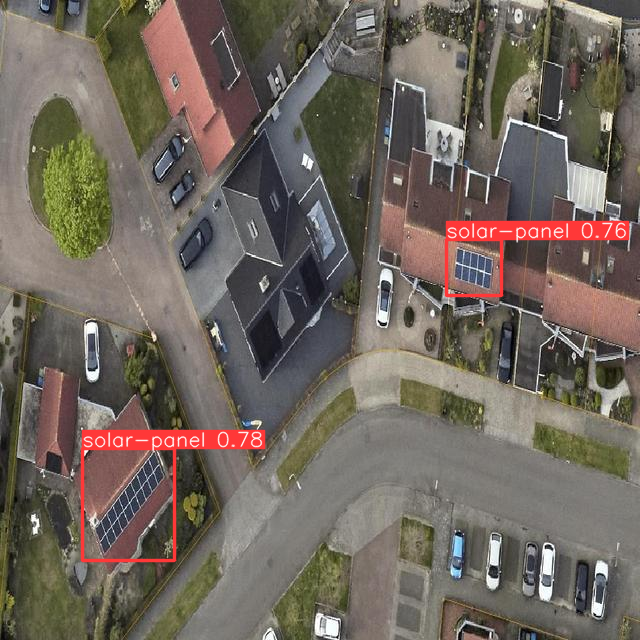

In [ ]:
from PIL import Image
import cv2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
#Hier resize je de afbeeldingen naar dezelfde resolutie als de trainingsdata.
def resize_image(input_path, output_path, size=(640, 640)):
    # Open de afbeelding
    image = Image.open(input_path)
    # Herschaal de afbeelding met de LANCZOS methode
    resized_image = image.resize(size, Image.Resampling.LANCZOS)
    # Sla de aangepaste afbeelding op
    resized_image.save(output_path)

input_path = '/content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/nieuwe_afbeeldingen/afbeeldingen_origineel/Export.jpg'
output_path = '/content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/nieuwe_afbeeldingen/afbeeldingen_resized/Export_640.jpg'
resize_image(input_path, output_path)




#Voorspelling doen
model = YOLO('/content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/Runs v2 content/solar-panelv2/weights/best.pt')
results = model('/content/drive/MyDrive/Colab Notebooks/yolov8_zonnepanelen/nieuwe_afbeeldingen/afbeeldingen_resized/Export_640.jpg')

for r in results:
    im_array = r.plot()  # plot een BGR numpy array van de voorspellingen
    # RGB PIL afbeelding
    im = Image.fromarray(im_array[..., ::-1])
    # Open-CV leest afbeeldingen als BGR, we converteren het naar RGB
    img = cv2.cvtColor(im_array[..., ::-1], cv2.COLOR_BGR2RGB)
    cv2_imshow(img)